In [93]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import __qiskit_version__
%matplotlib inline  

In [94]:
__qiskit_version__

{'qiskit-terra': '0.15.2',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.8.0.dev0+b295968',
 'qiskit': '0.20.0'}

# 1. Construct and map the Fermionic Hamiltonian

<br>

<div>
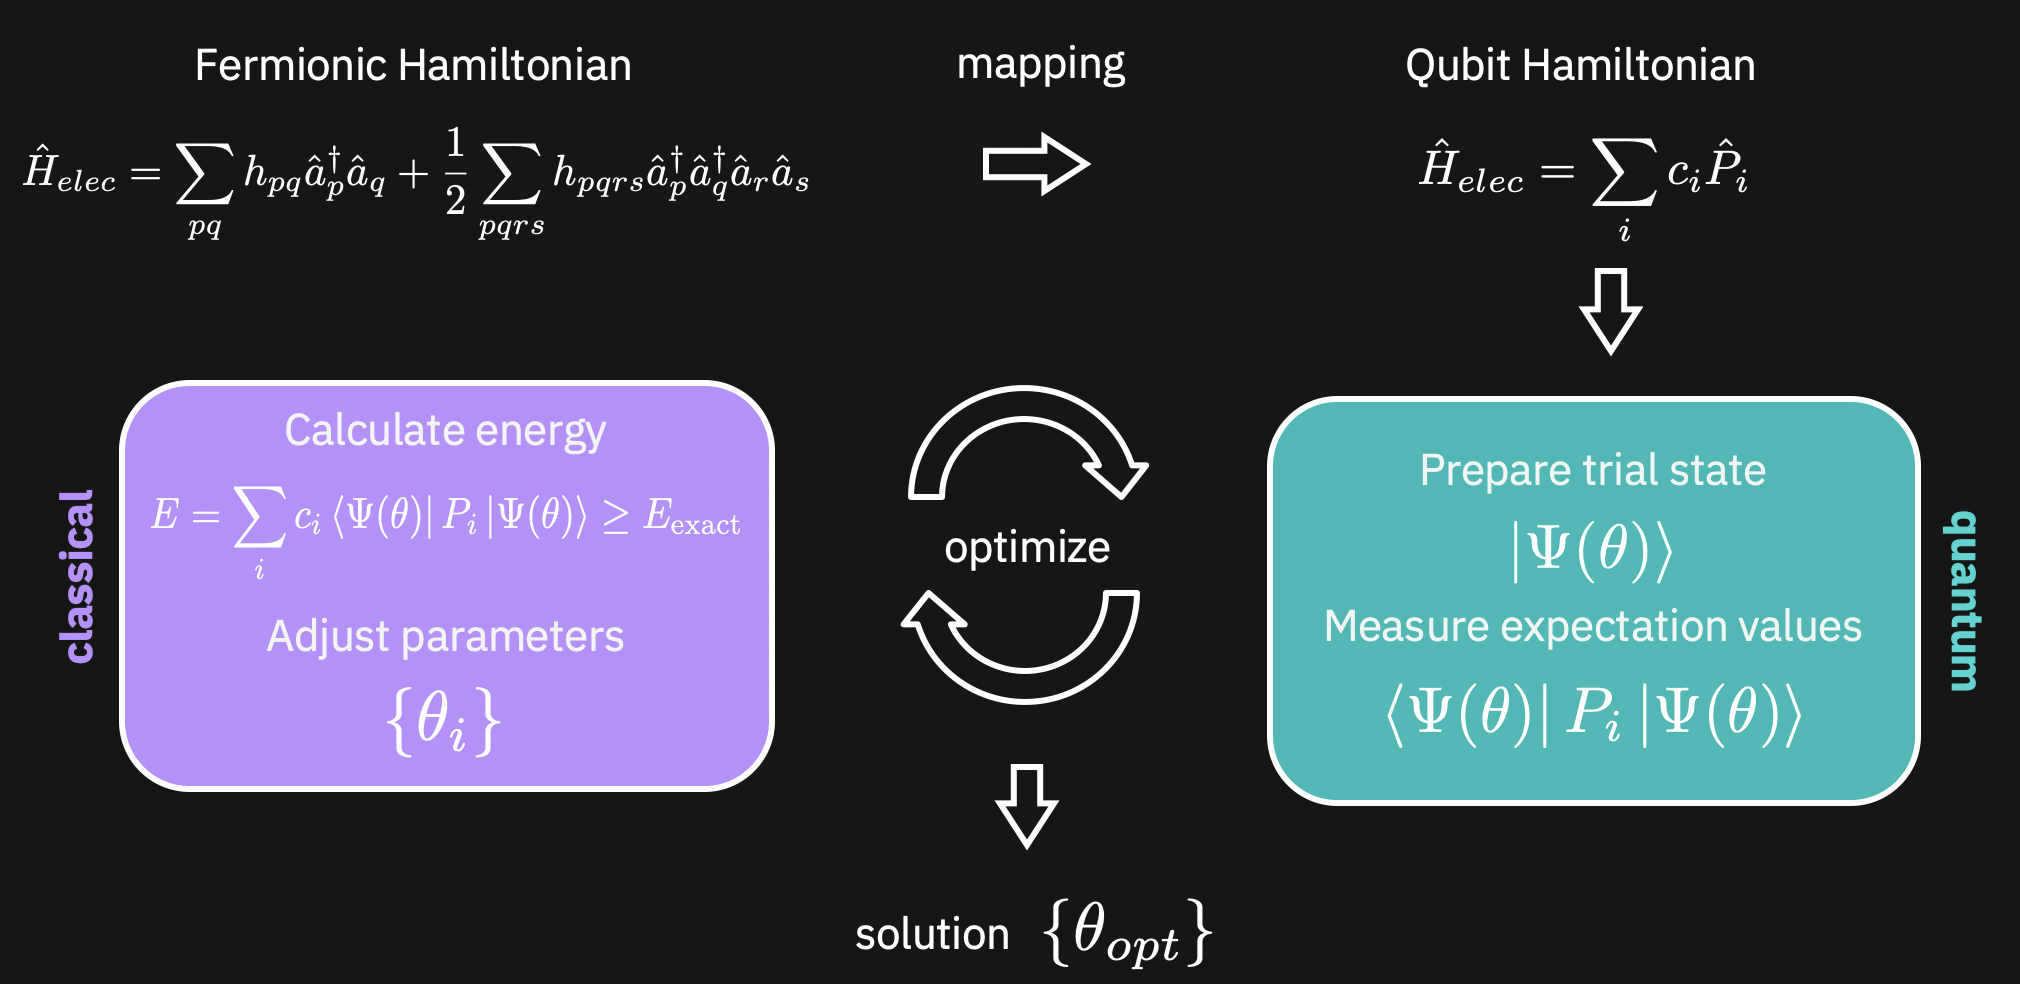
</div>

In [11]:
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

In [12]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.75', unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# of electrons: {}".format(num_particles))
print("# of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -1.8217210634986012
# of electrons: 2
# of spin orbitals: 4


In [13]:
from qiskit.chemistry import FermionicOperator

In [10]:
ferop = FermionicOperator(h1=h1, h2=h2)
map_type = 'jordan_wigner'
qubitop = ferop.mapping(map_type=map_type)
print(qubitop.print_details())

IIII	(-0.8153001706270075+0j)
IIIZ	(0.16988452027940318+0j)
IIZI	(-0.21886306781219608+0j)
IZII	(0.16988452027940323+0j)
ZIII	(-0.2188630678121961+0j)
IIZZ	(0.12005143072546047+0j)
IZIZ	(0.16821198673715723+0j)
XXYY	(0.04544288414432624+0j)
YYYY	(0.04544288414432624+0j)
XXXX	(0.04544288414432624+0j)
YYXX	(0.04544288414432624+0j)
ZIIZ	(0.16549431486978672+0j)
IZZI	(0.16549431486978672+0j)
ZIZI	(0.1739537877649417+0j)
ZZII	(0.12005143072546047+0j)



# 2. Prepare the quantum state

<br>

<div>
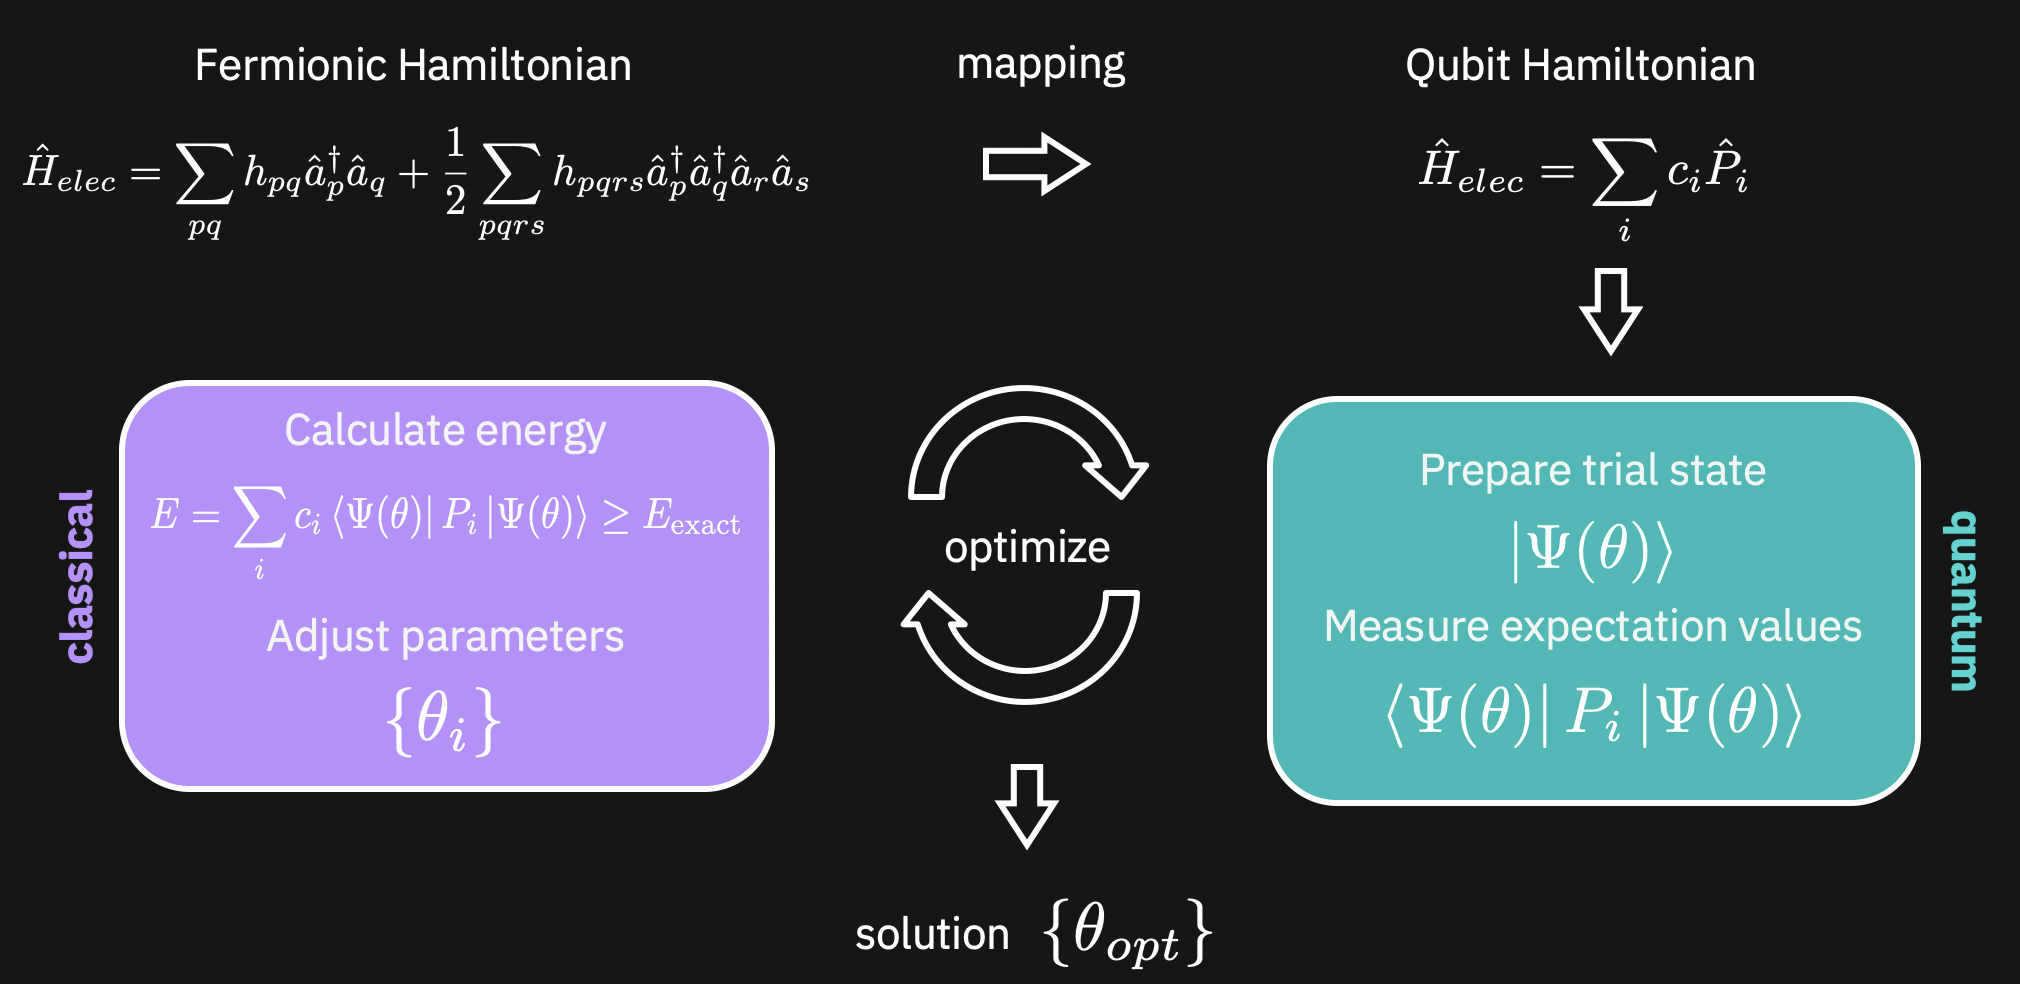
</div>

## i. Use built-in   *initial states*   and   *variational forms*

In [18]:
from qiskit.chemistry.components.initial_states import HartreeFock

qubit_reduction = False
HF_state = HartreeFock(num_spin_orbitals, num_particles, map_type, qubit_reduction)
print(HF_state.construct_circuit())

     ┌─────────────┐
q_0: ┤ U3(pi,0,pi) ├
     └─────────────┘
q_1: ───────────────
     ┌─────────────┐
q_2: ┤ U3(pi,0,pi) ├
     └─────────────┘
q_3: ───────────────
                    


In [28]:
from qiskit.chemistry.components.variational_forms import UCCSD

uccsd_var_form = UCCSD( num_orbitals=num_spin_orbitals, num_particles=num_particles,
                   initial_state=HF_state, qubit_mapping=map_type, 
                   two_qubit_reduction=qubit_reduction)

print("Single excitation indices:", uccsd_var_form.single_excitations)
print("Double excitation indices:", uccsd_var_form.double_excitations)

Single excitation indices: [[0, 1], [2, 3]]
Double excitation indices: [[0, 1, 2, 3]]


In [31]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

x = ParameterVector('x', uccsd_var_form._num_parameters)
uccsd_circuit = QuantumCircuit(uccsd_var_form.num_qubits)
uccsd_circuit.compose(uccsd_var_form.construct_circuit(x), inplace=True)

print(uccsd_circuit.decompose())

         ┌─────────────┐    ┌──────────┐                          »
q_0: ────┤ U3(pi,0,pi) ├────┤ U2(0,pi) ├──■────────────────────■──»
     ┌───┴─────────────┴───┐└──────────┘┌─┴─┐┌──────────────┐┌─┴─┐»
q_1: ┤ U3(pi/2,-pi/2,pi/2) ├────────────┤ X ├┤ U1(1.0*x[0]) ├┤ X ├»
     └───┬─────────────┬───┘┌──────────┐└───┘└──────────────┘└───┘»
q_2: ────┤ U3(pi,0,pi) ├────┤ U2(0,pi) ├──■────────────────────■──»
     ┌───┴─────────────┴───┐└──────────┘┌─┴─┐┌──────────────┐┌─┴─┐»
q_3: ┤ U3(pi/2,-pi/2,pi/2) ├────────────┤ X ├┤ U1(1.0*x[1]) ├┤ X ├»
     └─────────────────────┘            └───┘└──────────────┘└───┘»
«           ┌──────────┐      ┌─────────────────────┐                      »
«q_0: ──────┤ U2(0,pi) ├──────┤ U3(pi/2,-pi/2,pi/2) ├──■───────────────────»
«     ┌─────┴──────────┴─────┐└─────┬──────────┬────┘┌─┴─┐┌───────────────┐»
«q_1: ┤ U3(-pi/2,-pi/2,pi/2) ├──────┤ U2(0,pi) ├─────┤ X ├┤ U1(-1.0*x[0]) ├»
«     └─────┬──────────┬─────┘┌─────┴──────────┴────┐└───┘└───────────────┘»
«q_

## ii. Build your own parametrized circuit

In [60]:
from qiskit.circuit.library import TwoLocal

num_qubits = 4
tl_circuit = TwoLocal(num_qubits, ['h', 'rx'], 'cz', entanglement='full', reps=3, parameter_prefix = 'y')

print(tl_circuit)

     ┌───┐┌──────────┐            ┌───┐┌──────────┐                           »
q_0: ┤ H ├┤ RX(y[0]) ├─■──■─────■─┤ H ├┤ RX(y[4]) ├─────────────────■───────■─»
     ├───┤├──────────┤ │  │     │ └───┘└──┬───┬───┘┌──────────┐     │       │ »
q_1: ┤ H ├┤ RX(y[1]) ├─■──┼──■──┼───■─────┤ H ├────┤ RX(y[5]) ├─────■───────┼─»
     ├───┤├──────────┤    │  │  │   │     └───┘    └──┬───┬───┘┌──────────┐ │ »
q_2: ┤ H ├┤ RX(y[2]) ├────■──■──┼───┼───────■─────────┤ H ├────┤ RX(y[6]) ├─■─»
     ├───┤├──────────┤          │   │       │         ├───┤    ├──────────┤   »
q_3: ┤ H ├┤ RX(y[3]) ├──────────■───■───────■─────────┤ H ├────┤ RX(y[7]) ├───»
     └───┘└──────────┘                                └───┘    └──────────┘   »
«           ┌───┐┌──────────┐                                  ┌───┐»
«q_0: ────■─┤ H ├┤ RX(y[8]) ├──────────────────■───────■─────■─┤ H ├»
«         │ └───┘└──┬───┬───┘┌──────────┐      │       │     │ └───┘»
«q_1: ─■──┼───■─────┤ H ├────┤ RX(y[9]) ├──────■───────┼──■──┼───■──»


In [43]:
from qiskit.circuit import Parameter

my_circuit = QuantumCircuit(num_qubits)
my_circuit.x(range(num_qubits))
my_circuit.rz(Parameter('z1'),1)
my_circuit.rz(Parameter('z2'),2)
my_circuit.cx(0,2)

print(my_circuit)

     ┌───┐               
q_0: ┤ X ├────────────■──
     ├───┤┌────────┐  │  
q_1: ┤ X ├┤ RZ(z1) ├──┼──
     ├───┤├────────┤┌─┴─┐
q_2: ┤ X ├┤ RZ(z2) ├┤ X ├
     ├───┤└────────┘└───┘
q_3: ┤ X ├───────────────
     └───┘               


# 3. Prepare the backend and the optimizer to run a VQE calculation

<br>

<div>
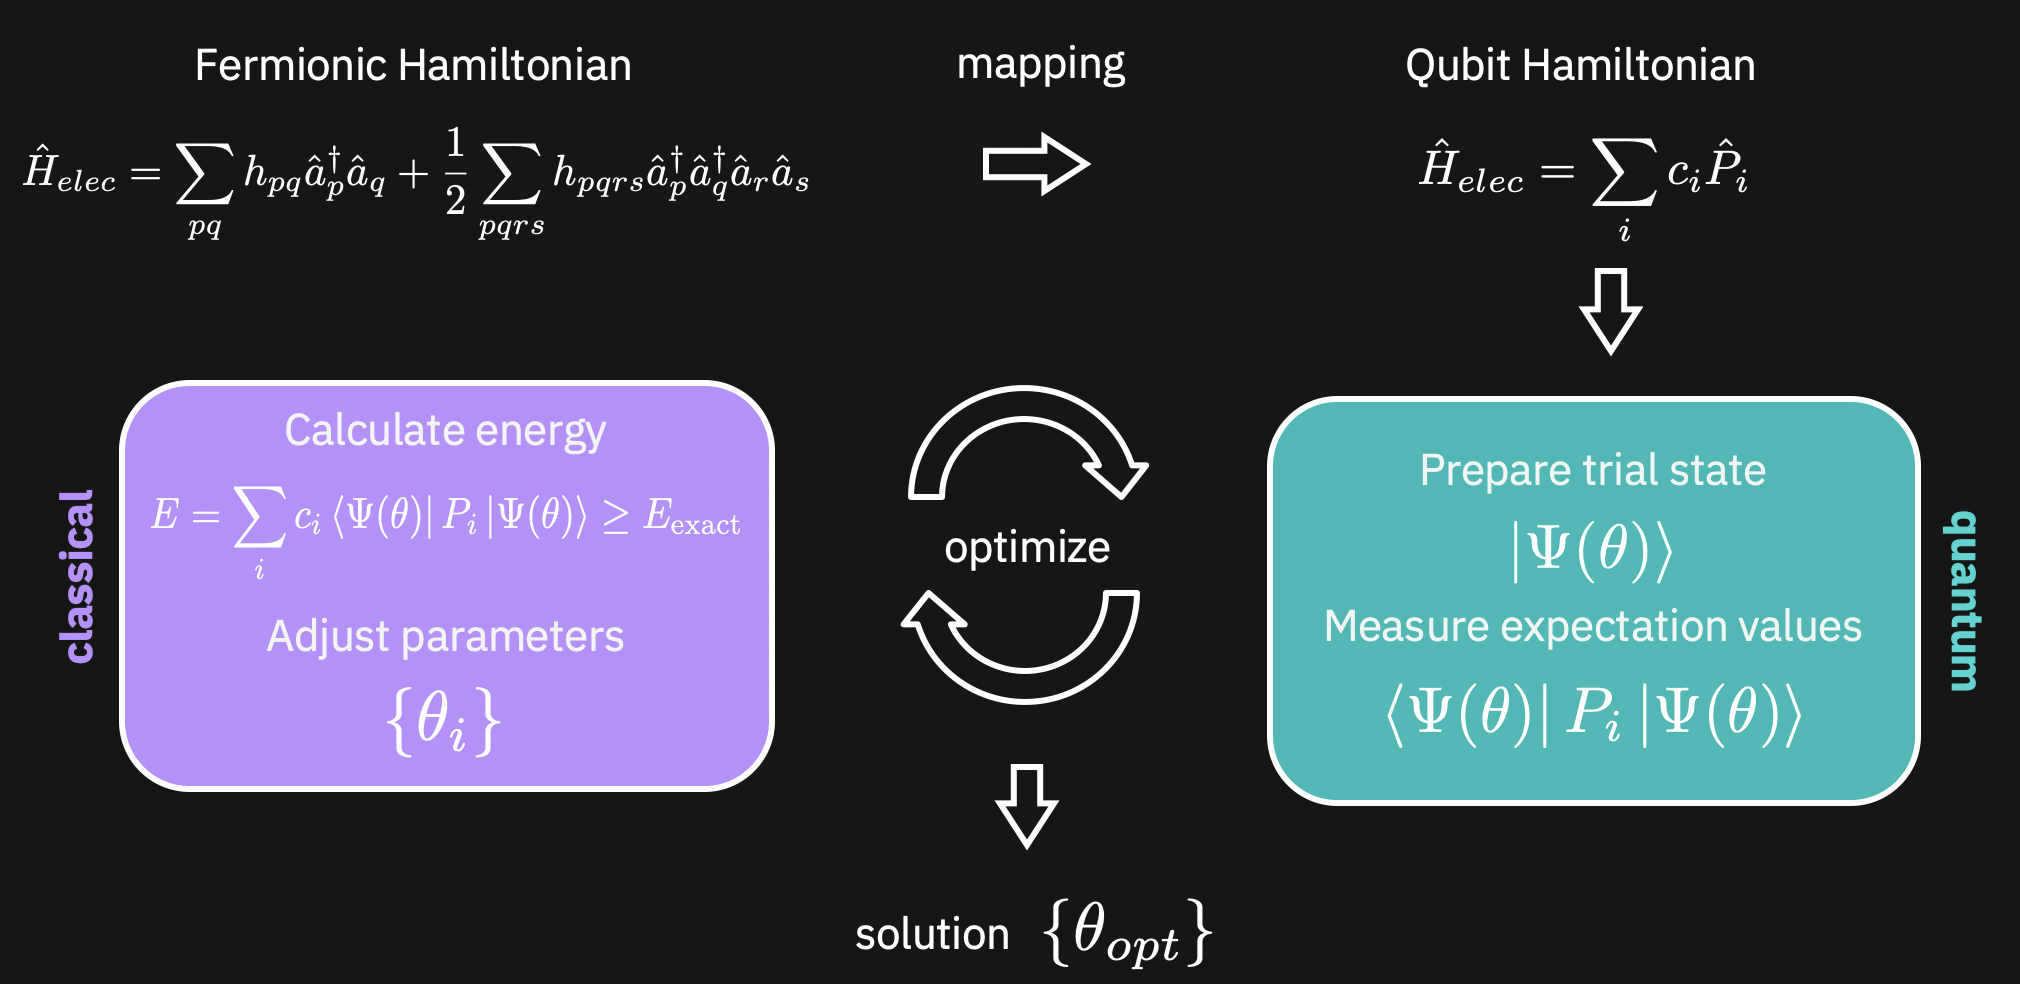
</div>


In [82]:
from qiskit import Aer
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA

In [83]:
backend = Aer.get_backend('statevector_simulator')
cobyla = COBYLA(maxiter=400)

In [84]:
vqe = VQE(qubitop, uccsd_var_form, cobyla)
results = vqe.run(backend)
print('The computed ground state energy is: {:.12f}'.format(results['eigenvalue']))
print("Parameters: {}".format(results['optimal_point']))
print("Number of iterations: {}".format(results['optimizer_evals']))

The computed ground state energy is: -1.842686670717+0.000000000000j
Parameters: [-2.99936215e-05  4.01177188e-05 -1.14755210e-01]
Number of iterations: 43


In [63]:
vqe = VQE(qubitop, tl_circuit, cobyla)
results = vqe.run(backend)
print('The computed ground state energy is: {:.12f}'.format(results['eigenvalue']))
print("Parameters: {}".format(results['optimal_point']))
print("Number of iterations: {}".format(results['optimizer_evals']))

The computed ground state energy is: -1.842686677380+0.000000000000j
Parameters: [-0.36552226 -2.08817809  4.98362025  1.57071923  7.85398518 -1.57083002
 -4.71246768 -4.38948965 -0.72147352 -5.6575822   1.57077262 -1.57077516
  4.71242084  4.71239858 -3.04264158 -2.56689205]
Number of iterations: 356


## Use a callback function to check the convergence

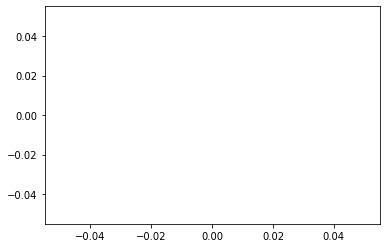

In [97]:
counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    
vqe = VQE(qubitop, uccsd_var_form, cobyla, callback=store_intermediate_result)

plt.plot(counts, values)

# 4. Extend the VQE to the excited states

In [69]:
from qiskit.chemistry.algorithms import QEomVQE


qeom = QEomVQE(operator = qubitop, var_form = uccsd_var_form, 
               optimizer = cobyla, num_orbitals= num_spin_orbitals,
               num_particles= num_particles, qubit_mapping= map_type, 
               two_qubit_reduction = False, quantum_instance = backend)

results = qeom.run()
print("The excited states energies are: {}".format(results['energies']))

The excited states energies are: [-1.84268667 -1.24838077 -0.88483769 -0.24579415]


# 5. Check your results

In [90]:
from qiskit.aqua.algorithms import NumPyEigensolver

def print_state(psi):
    for i in range(len(psi)):
        if np.conj(psi[i]) * psi[i] > 1e-7:
            print('\t', np.binary_repr(i, num_qubits), np.real(np.conj(psi[i]) * psi[i]))

exact_eigensolver = NumPyEigensolver(qubitop, k=1<<qubitop.num_qubits)
results = exact_eigensolver.run()

eigenvalues = results['eigenvalues']

In [91]:
print("The exact eigenstates and eigenvalues of this Hamiltonian are:")

for i in range(len(eigenvalues)):
    print("\n Eigenstate {} --> {} Ha".format(i, np.real(eigenvalues[i])))
    print_state(results['eigenstates'][i].primitive.data)

The exact eigenstates and eigenvalues of this Hamiltonian are:

 Eigenstate 0 --> -1.8426866819057308 Ha
	 0101 0.98687122865069
	 1010 0.013128771349309714

 Eigenstate 1 --> -1.248351713417759 Ha
	 1100 1.0

 Eigenstate 2 --> -1.2483517134177589 Ha
	 0110 0.5000000000000002
	 1001 0.4999999999999998

 Eigenstate 3 --> -1.2483517134177589 Ha
	 0011 1.0

 Eigenstate 4 --> -1.2472845052236152 Ha
	 0100 1.0

 Eigenstate 5 --> -1.247284505223615 Ha
	 0001 1.0

 Eigenstate 6 --> -1.1608110122135984 Ha
	 0111 1.0

 Eigenstate 7 --> -1.1608110122135984 Ha
	 1101 1.0

 Eigenstate 8 --> -0.8848086402631492 Ha
	 0110 0.4999999999999998
	 1001 0.5000000000000002

 Eigenstate 9 --> -0.4812729310959856 Ha
	 0010 1.0

 Eigenstate 10 --> -0.48127293109598557 Ha
	 1000 1.0

 Eigenstate 11 --> -0.371832233974831 Ha
	 1110 1.0

 Eigenstate 12 --> -0.3718322339748308 Ha
	 1011 1.0

 Eigenstate 13 --> -0.24576509272507513 Ha
	 0101 0.013128771349309717
	 1010 0.98687122865069

 Eigenstate 14 --> -1.24900